In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv('train.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


## 1. Проведем анализ данных

In [3]:
# Подготовим новый датафрейм, чтобы не сломать исходный
df_new = df.copy()

In [4]:
df_new.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Pclass — класс пассажира (1 — высший, 2 — средний, 3 — низший);  
Name — имя;  
Sex — пол;  
Age — возраст;  
SibSp — число братьев, сестер или супругов на борту у человека;  
Parch — количество родителей или детей пассажира;  
Ticket — номер билета;  
Fare — плата за проезд;  
Cabin — каюта;  
Embarked — порт посадки

In [5]:
df_new.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Text(0, 0.5, 'missing value in %')

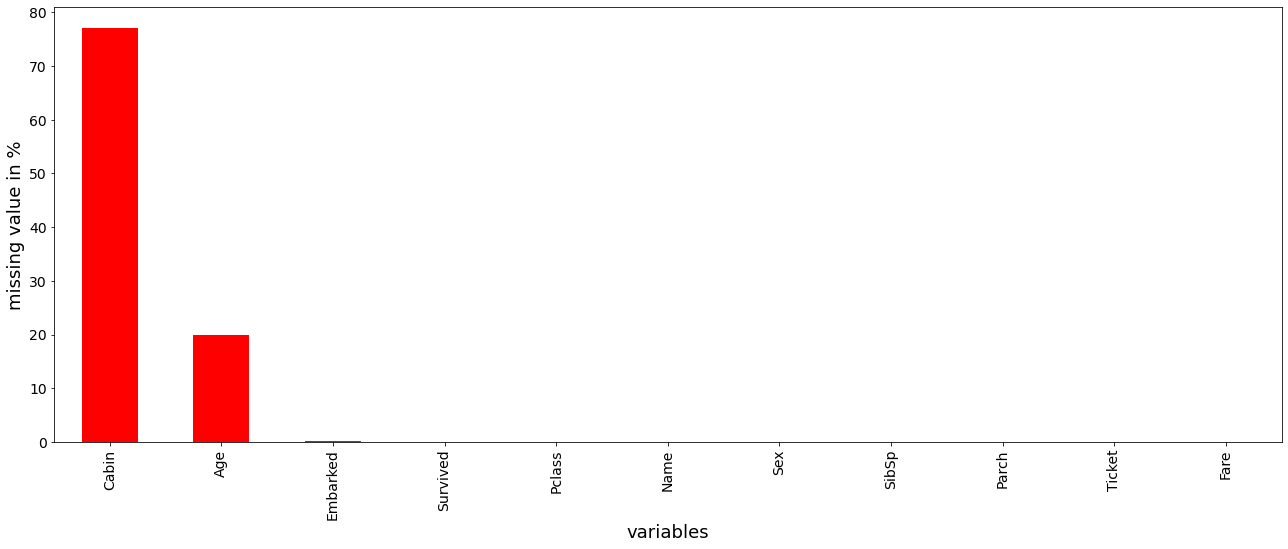

In [6]:
pd.isnull(df).sum(axis=0)

series = pd.isnull(df).sum(axis=0) * 100 / len(df)

series.sort_values(ascending=False).plot(kind='bar', fontsize=14, figsize=(22, 8), color='red')
plt.xlabel('variables', fontsize=18)
plt.ylabel('missing value in %', fontsize=18)

> Видим, что много пропусков по каютам и возрасту, есть пропуски по пункту отправления

In [7]:
# Для начального анализа заменим пропущенный возраст медианой (хотя это не правильно в данном случае)
df_new['Age'] = df_new['Age'].fillna(df_new['Age'].median())


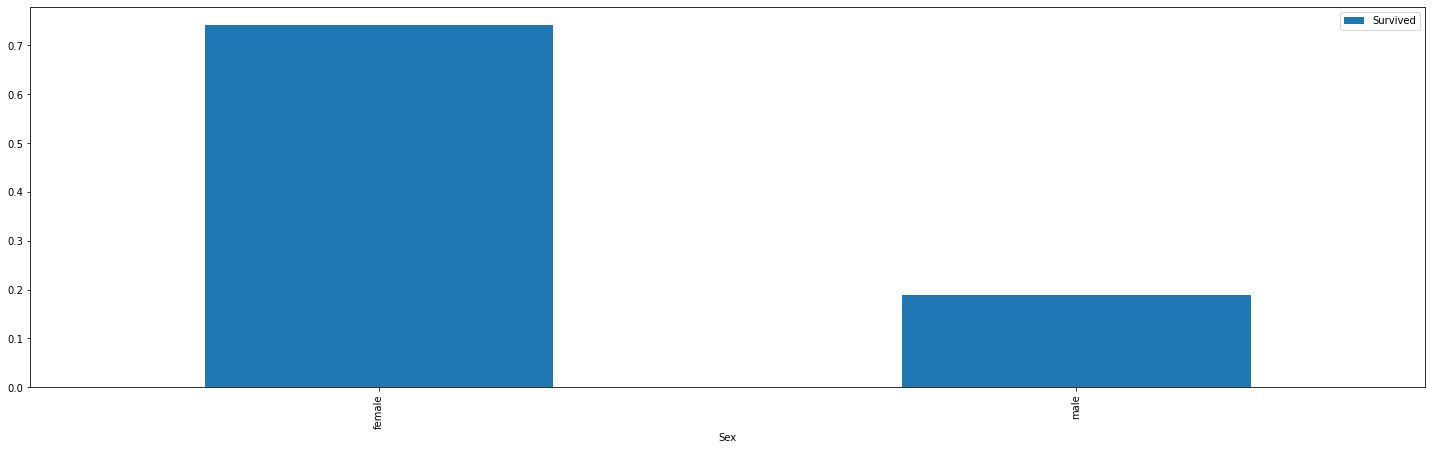

In [8]:
# Посмотрим на гистограмму выживаемости по полу
df_new.groupby('Sex').agg('mean')[['Survived']].plot(kind='bar',
                                                    figsize=(25, 7),
                                                   );

> Похоже, что женщин выжило больше, аж почти 80%

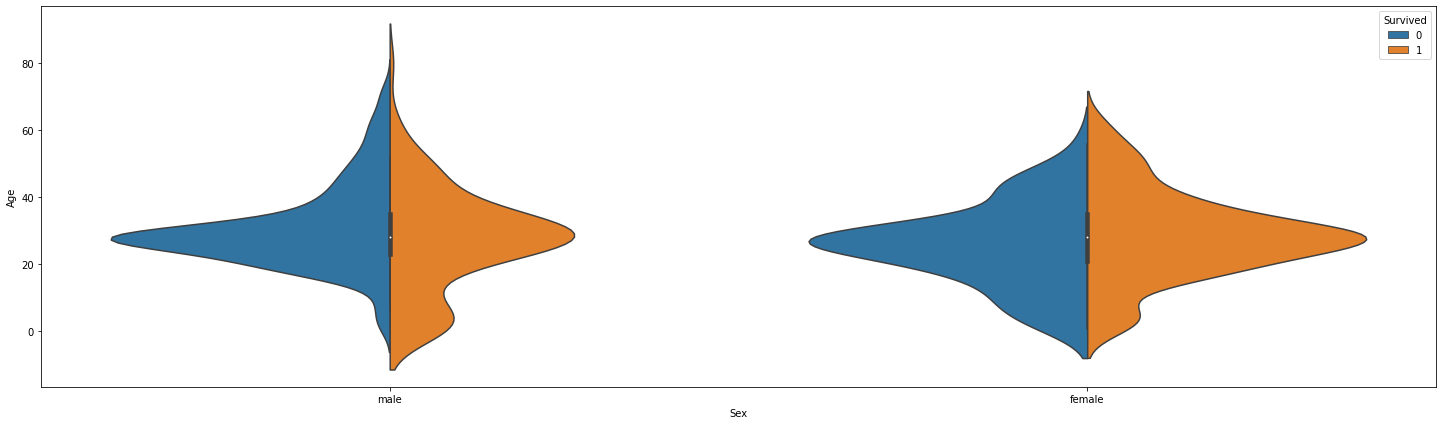

In [9]:
# Посмотрим распределение выживаемости по возрасту и полу
fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Sex', y='Age', 
               hue='Survived', data=df_new, 
               split=True,
              );

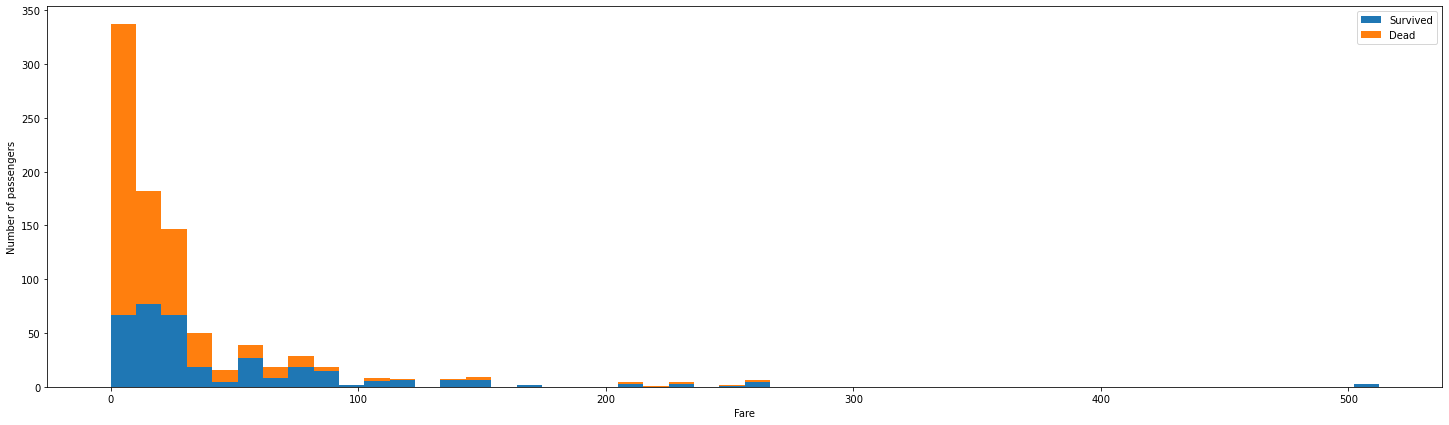

In [10]:
# Посмотрим распределение выживаемости по цене билета
figure = plt.figure(figsize=(25, 7))
plt.hist([df_new[df_new['Survived'] == 1]['Fare'], df_new[df_new['Survived'] == 0]['Fare']], 
         stacked=True,
         bins = 50,
         label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend();

> Видно, что дешевые билеты большей частью не выжили

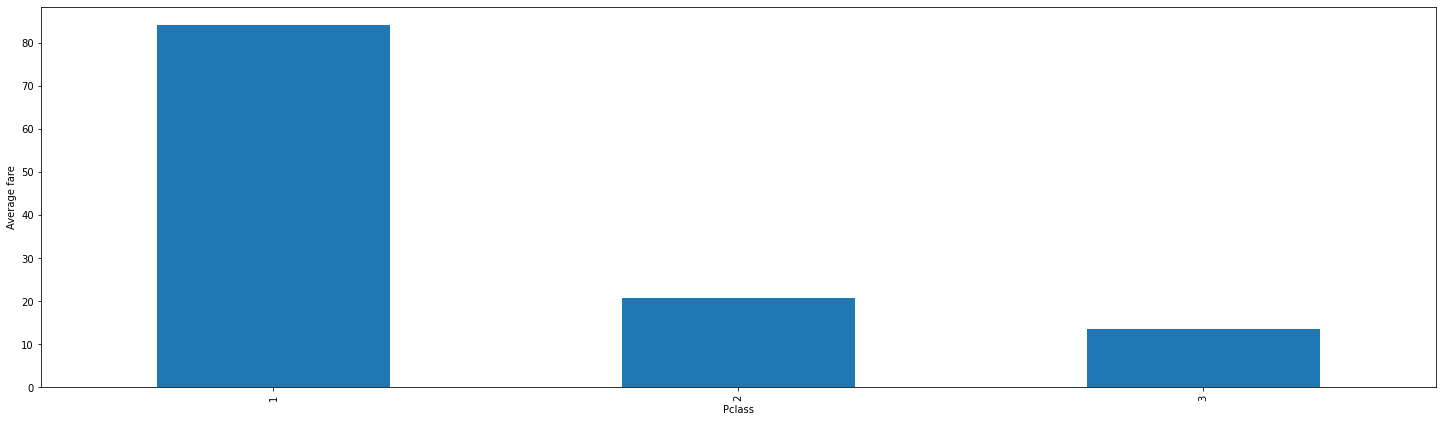

In [11]:
ax = plt.subplot()
ax.set_ylabel('Average fare')
df_new.groupby('Pclass').mean()['Fare'].plot(kind='bar', figsize=(25, 7), ax = ax);

> Видим, что логично, стоимость билета коррелирует с классом.  
  
  На этом закончим анализ и приступим к обработке данных

## 2 Обработка датафрейма

In [12]:
# Выделим из Name Фамилии пассажиров
surname = []
for entry in df["Name"].items():
     surname.append(entry[1].split(',')[0])
        
df['surname'] = surname

In [13]:
# Выберем тип каюты, пропускам пока присвоим U - unknown, в дальнейшем надо будет заменить на медиану по цене
df["cabin_type"] = df["Cabin"].fillna("U").apply(lambda c: c[0])

In [14]:
# Выберем титулы пассажиров
df['title'] = df.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
df['title']

PassengerId
1        Mr
2       Mrs
3      Miss
4       Mrs
5        Mr
       ... 
887     Rev
888    Miss
889    Miss
890      Mr
891      Mr
Name: title, Length: 891, dtype: object

In [15]:
# Разобьем титулы по категориям
normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}
# сопоставим категории титулов с текущими титулами 
df.title = df.title.map(normalized_titles)
# посмотрим количество титулов по категориям
print(df.title.value_counts())

Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: title, dtype: int64


Обработаем пропуски по возрасту заменив медианами

In [16]:
# группируем по полу, классу кают и титулам 
grouped = df.groupby(['Sex','Pclass', 'title'])  
# посмотрим возрастную медиану сгруппированного датафрейма  
grouped.Age.median()

Sex     Pclass  title  
female  1       Miss       30.0
                Mrs        40.0
                Officer    49.0
                Royalty    40.5
        2       Miss       24.0
                Mrs        31.5
        3       Miss       18.0
                Mrs        31.0
male    1       Master      4.0
                Mr         40.0
                Officer    51.0
                Royalty    40.0
        2       Master      1.0
                Mr         31.0
                Officer    46.5
        3       Master      4.0
                Mr         26.0
Name: Age, dtype: float64

In [17]:
# заменяем пропуски по возрасту медианой
df.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))

Обработаем остальные пропуски

In [18]:
# заменяем пропуски по каютам на U - unknown
df.Cabin = df.Cabin.fillna('U')
# порт посадки 
most_embarked = df.Embarked.value_counts().index[0]

# fill NaN with most_embarked value
df.Embarked = df.Embarked.fillna(most_embarked)
# fill NaN with median fare
df.Fare = df.Fare.fillna(df.Fare.median())

# view changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Name        891 non-null    object 
 3   Sex         891 non-null    object 
 4   Age         891 non-null    float64
 5   SibSp       891 non-null    int64  
 6   Parch       891 non-null    int64  
 7   Ticket      891 non-null    object 
 8   Fare        891 non-null    float64
 9   Cabin       891 non-null    object 
 10  Embarked    891 non-null    object 
 11  surname     891 non-null    object 
 12  cabin_type  891 non-null    object 
 13  title       891 non-null    object 
dtypes: float64(2), int64(4), object(8)
memory usage: 136.7+ KB


In [19]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname,cabin_type,title
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,Braund,U,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,C,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,Heikkinen,U,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,C,Mrs
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,Allen,U,Mr


Подготовим обработанный датафрейм для модели

In [36]:
droped_features = ['Name', 'Ticket',  'Cabin', 'surname','Embarked'] #'Fare',]

In [37]:
preprocessing_df = df.drop(columns=droped_features)


In [38]:
preprocessing_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,cabin_type,title
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,U,Mr
2,1,1,female,38.0,1,0,71.2833,C,Mrs
3,1,3,female,26.0,0,0,7.9250,U,Miss
4,1,1,female,35.0,1,0,53.1000,C,Mrs
5,0,3,male,35.0,0,0,8.0500,U,Mr
...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0000,U,Officer
888,1,1,female,19.0,0,0,30.0000,B,Miss
889,0,3,female,18.0,1,2,23.4500,U,Miss


In [39]:
# Проверим пропуски
preprocessing_df[preprocessing_df.isnull().any(axis=1)]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,cabin_type,title
PassengerId,,,,,,,,,


> Отлично. Пропусков в подготовленной датасете нет.  
  
  Сохраним его для загрузки в обучаемую модель

In [40]:
preprocessing_df.to_csv('preprocessing_df.csv', index=True) 

## Подготовим тестовый датафрейм

In [41]:
df_test = pd.read_csv('test.csv', index_col=0)
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [42]:
# Выделим из Name Фамилии пассажиров
surname_test = []
for entry in df_test["Name"].items():
     surname_test.append(entry[1].split(',')[0])    
df_test['surname'] = surname_test

# Выберем тип каюты, пропускам пока присвоим U - unknown, в дальнейшем надо будет заменить на медиану по цене
df_test["cabin_type"] = df_test["Cabin"].fillna("U").apply(lambda c: c[0])
# Выберем титулы пассажиров
df_test['title'] = df_test.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
df_test['title']

PassengerId
892         Mr
893        Mrs
894         Mr
895         Mr
896        Mrs
         ...  
1305        Mr
1306      Dona
1307        Mr
1308        Mr
1309    Master
Name: title, Length: 418, dtype: object

In [43]:
# сопоставим категории титулов с текущими титулами 
df_test.title = df_test.title.map(normalized_titles)

In [44]:
# группируем по полу, классу кают и титулам 
grouped_test = df_test.groupby(['Sex','Pclass', 'title'])  
# посмотрим возрастную медиану сгруппированного датафрейма  
grouped_test.Age.median()
# заменяем пропуски по возрасту медианой
df_test.Age = grouped_test.Age.apply(lambda x: x.fillna(x.median()))

In [45]:
# заменяем пропуски по каютам на U - unknown
df_test.Cabin = df_test.Cabin.fillna('U')
# порт посадки 
most_embarked_test = df_test.Embarked.value_counts().index[0]

# fill NaN with most_embarked value
df_test.Embarked = df_test.Embarked.fillna(most_embarked_test)
# fill NaN with median fare
df_test.Fare = df_test.Fare.fillna(df_test.Fare.median())

# view changes
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Name        418 non-null    object 
 2   Sex         418 non-null    object 
 3   Age         418 non-null    float64
 4   SibSp       418 non-null    int64  
 5   Parch       418 non-null    int64  
 6   Ticket      418 non-null    object 
 7   Fare        418 non-null    float64
 8   Cabin       418 non-null    object 
 9   Embarked    418 non-null    object 
 10  surname     418 non-null    object 
 11  cabin_type  418 non-null    object 
 12  title       418 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 45.7+ KB


In [46]:
preprocessing_df_test = df_test.drop(columns=droped_features)

In [47]:
preprocessing_df_test

,Pclass,Sex,Age,SibSp,Parch,Fare,cabin_type,title
PassengerId,,,,,,,,
892,3,male,34.5,0,0,7.8292,U,Mr
893,3,female,47.0,1,0,7.0000,U,Mrs
894,2,male,62.0,0,0,9.6875,U,Mr
895,3,male,27.0,0,0,8.6625,U,Mr
896,3,female,22.0,1,1,12.2875,U,Mrs
...,...,...,...,...,...,...,...,...
1305,3,male,25.0,0,0,8.0500,U,Mr
1306,1,female,39.0,0,0,108.9000,C,Royalty
1307,3,male,38.5,0,0,7.2500,U,Mr


In [48]:
# Проверим пропуски
preprocessing_df_test[preprocessing_df_test.isnull().any(axis=1)]

,Pclass,Sex,Age,SibSp,Parch,Fare,cabin_type,title
PassengerId,,,,,,,,


In [49]:
preprocessing_df_test.to_csv('preprocessing_df_test.csv', index=True) 